In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

In [2]:
weather_df = pd.read_csv('weatherHistory.csv')
weather_df.head()

weather_df=weather_df.rename(columns={'Formatted Date':'formatted_date','Summary':'summary','Precip Type':'precip_type','Temperature (C)':'temp_C',
                      'Apparent Temperature (C)':'app_temp_C','Humidity':'humidity','Wind Speed (km/h)':'wind_speed',
                      'Wind Bearing (degrees)':'wind_bearing','Visibility (km)':'visibility','Loud Cover':'cloud_cover',
                     'Pressure (millibars)':'pressure','Daily Summary':'daily_summary'})
weather_df.head()

,formatted_date,summary,precip_type,temp_C,app_temp_C,humidity,wind_speed,wind_bearing,visibility,cloud_cover,pressure,daily_summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.


In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
formatted_date    96453 non-null object
summary           96453 non-null object
precip_type       95936 non-null object
temp_C            96453 non-null float64
app_temp_C        96453 non-null float64
humidity          96453 non-null float64
wind_speed        96453 non-null float64
wind_bearing      96453 non-null float64
visibility        96453 non-null float64
cloud_cover       96453 non-null float64
pressure          96453 non-null float64
daily_summary     96453 non-null object
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [4]:
object_columns = weather_df.select_dtypes(['object']).columns
print(object_columns)

Index(['formatted_date', 'summary', 'precip_type', 'daily_summary'], dtype='object')


In [5]:
numeric_columns = weather_df.select_dtypes(['float64']).columns
print(numeric_columns)

Index(['temp_C', 'app_temp_C', 'humidity', 'wind_speed', 'wind_bearing',
       'visibility', 'cloud_cover', 'pressure'],
      dtype='object')


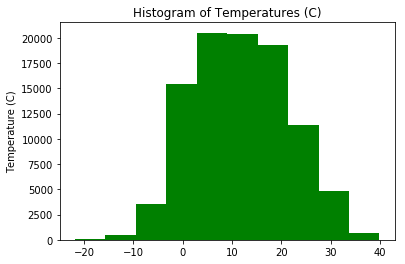

In [6]:
plt.hist(weather_df.temp_C, color='green')
plt.title('Histogram of Temperatures (C)')
plt.ylabel("Temperature (C)")
plt.show()

In [18]:
Y = weather_df['temp_C']

X = weather_df[['wind_speed','wind_bearing','pressure']]

lrm = linear_model.LinearRegression()

lrm.fit(X,Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

predictions = lrm.predict(X)
errors = Y - predictions


Coefficients: 
 [ 0.00783734  0.00261    -0.00039406]

Intercept: 
 11.75389094635982


In [19]:
print("Mean of the errors in the temperatures model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: 1.732580075512612e-15


The temperature mean of errors is virtually 0. So this model meets this assumption.

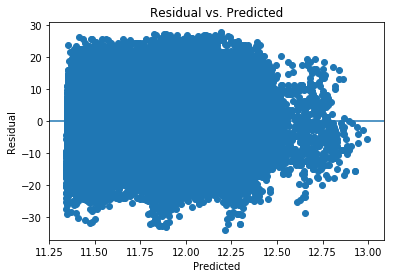

In [20]:
plt.scatter(predictions, errors)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.axhline(y=0)
plt.title("Residual vs. Predicted")
plt.show()

Looking at the scatter plot it appears that the variance of the errors is pretty equal across the graph. Meaning that we might have homoscedsticity.

In [21]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levine test statistic value is {0:3g} is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 536881 is 0
Levine test statistic value is 198368 is 0


Once we look at the statistical values of the predictions vs. errors we see that the p-value is "0". Meaning that we would dismiss the null hypothesis and accept that the errors are heteroscedastic.

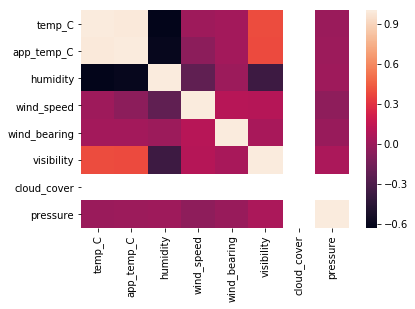

In [22]:
sns.heatmap(weather_df.corr())

Looking at the heatmap of of correlation of the features, it appears that only one of the features is highly correlated with the temperature. I remooved this from the features to confirm this assumption.

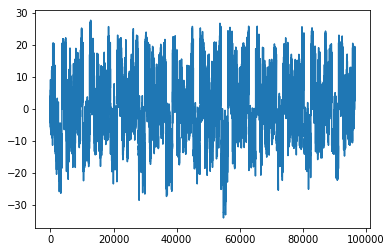

In [23]:
plt.plot(errors)
plt.show()

After plotting the errors it appears that they are disbursed randomly, meaning we can support assumption number 5, that error terms are uncorrelated.

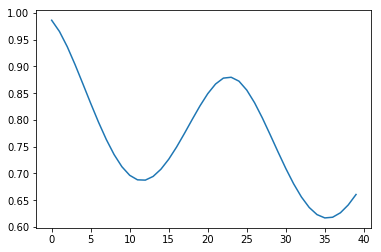

In [24]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.show()

An autocorrelation function displays a lack of correlation among the errors as well. The line would have a pattern to it not a curvy almost sinusodial curve.

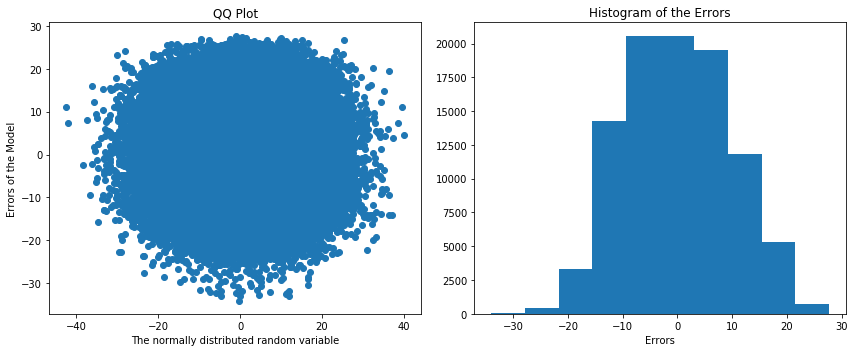

In [26]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(rand_nums, errors)
plt.xlabel("The normally distributed random variable")
plt.ylabel("Errors of the Model")
plt.title("QQ Plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("Errors")
plt.title("Histogram of the Errors")

plt.tight_layout()
plt.show()

In [27]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics in {0} and p-value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normal test statistics in {0} and p-value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics in 1467.0947086631702 and p-value is 0.0
Normal test statistics in 2851.6770046148263 and p-value is 0.0


The visuals of the errors in the QQ plot and the histogram show that they are not correlated. Although the histogram looks reasonably normal, the QQ plot shows no correlation and the p-values for both the Jarque-Bera and the Normal Test are "0". This shows that this assumption is not corrrect. 

With three of the six assumptions confirmed we can not consider these coefficients valid and the test statistics associated with them to be reliable.